In [1]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
import admix
import matplotlib.pyplot as plt
from utils import *
import dask
import dask.array as da
from tqdm import tqdm
import statsmodels.api as sm
from scipy.stats import pearsonr, ttest_ind
import seaborn as sns
from admix.data import quantile_normalize

# Export data to PLINK to perform GWAS

In [3]:
SUPP_TABLE_URL = "https://www.dropbox.com/s/jck2mhjby2ur55j/supp_tables.xlsx?dl=1"

In [4]:
trait_list = pd.read_excel(SUPP_TABLE_URL, sheet_name='trait-info')['trait'].values

In [5]:
dset = load_hm3()

df_pheno = pd.DataFrame({"FID": 0, "IID": dset['indiv'].values})
for trait in trait_list:
    df_pheno[trait] = quantile_normalize(dset[f"{trait}@indiv"].values)
                          
df_covar = pd.DataFrame({"FID": 0, "IID": dset['indiv'].values})

for col in ["age", "sex", "study"] + [f"geno_EV{i}" for i in range(1, 11)]:
    df_covar[col] = dset[col + "@indiv"].values

100%|██████████| 22/22 [00:02<00:00,  9.15it/s]


In [48]:
for trait in trait_list:
    non_nan_index = ~np.isnan(df_pheno[trait])
    df_trait_pheno = df_pheno.loc[non_nan_index, ["FID", "IID", trait]].copy()
    df_trait_covar = df_covar[non_nan_index].copy()
    study_dummies = pd.get_dummies(df_trait_covar["study"], drop_first=True)
    study_dummies.columns = [f"study_dummy_{s}" for s in study_dummies.columns]
    df_trait_covar = pd.concat([df_trait_covar, study_dummies], axis=1)
    df_trait_covar = df_trait_covar.drop(columns=["study"])
    df_trait_pheno.to_csv(f"out/plink_assoc/pheno.{trait}.txt", index=False, sep='\t', na_rep="NA")
    df_trait_covar.to_csv(f"out/plink_assoc/covar.{trait}.txt", index=False, sep='\t', na_rep="NA")

# Overall visualization of results

In [15]:
trait_list

array(['crp', 'total_wbc_cnt', 'mean_corp_hgb_conc', 'platelet_cnt',
       'hdl', 'ldl', 'triglycerides', 'total_cholesterol',
       'cigs_per_day_excl_nonsmk_updated', 'coffee_cup_day', 'a1c',
       'insulin', 'glucose', 't2d_status', 'qt_interval', 'qrs_interval',
       'pr_interval', 'systolic_bp', 'diastolic_bp', 'hypertension',
       'waist_hip_ratio', 'height', 'bmi', 'egfrckdepi'], dtype=object)

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found

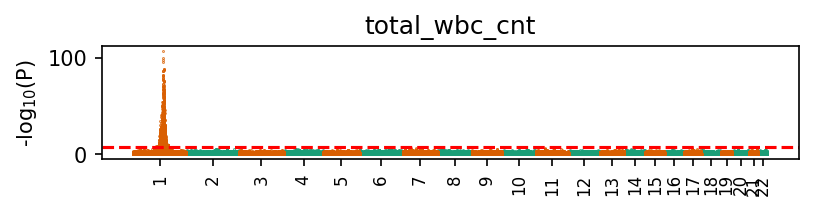

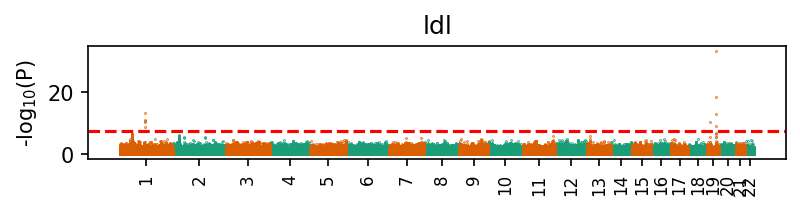

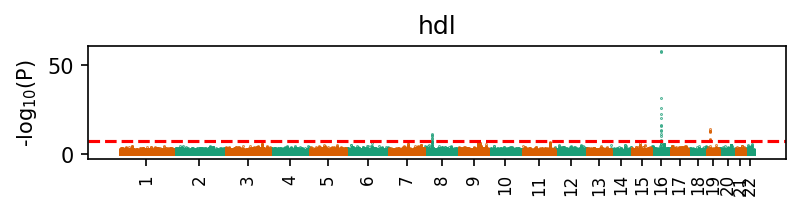

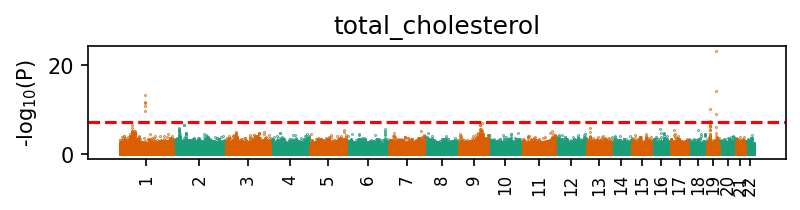

In [5]:
for trait in ["total_wbc_cnt", "ldl", "hdl", "total_cholesterol"]:
    assoc = pd.read_csv(f"out/plink_assoc/assoc.{trait}.glm.linear", delim_whitespace=True)
    fig, ax = plt.subplots(figsize=(6, 1), dpi=150)
    admix.plot.manhattan(pval=assoc["P"].values, chrom=assoc["#CHROM"].values, ax=ax)
    ax.set_title(trait)
    fig.show()

Also see 
- https://github.com/gokceneraslan/opentargets-genetics-python
- https://community.opentargets.org/t/how-to-access-finngen-gwas-data-using-the-open-targets-genetics-portal-api/254/4
- https://api.genetics.opentargets.org/graphql/schema

In [6]:
study_info_query = \
"""
    query test ($myStudyId: String! ) {
      studyInfo(studyId: $myStudyId) {
          traitReported
          source
          traitEfos
          pmid
          pubAuthor
          ancestryInitial
          numAssocLoci
          nTotal
      }
    }
"""

manhattan_query = \
"""
    query test ($myStudyId: String! ) {
      manhattan(studyId: $myStudyId) {
        associations {
          variant {
            id
            rsId
            chromosome
            position
            nearestCodingGene {
              id
              symbol
            }
            nearestCodingGeneDistance
          }
          pval
          credibleSetSize
          ldSetSize
          oddsRatio
          oddsRatioCILower
          oddsRatioCIUpper
          beta
          betaCILower
          betaCIUpper
          direction
        }
      }
    }
"""

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import statsmodels.api as sm
from scipy import stats
import admix
import xarray as xr
import numpy as np

In [96]:
def simulate(apa, beta, cov):
    cov_effects = np.random.normal(loc=0, scale=0.1, size=cov.shape[1])
    y = np.dot(apa, beta) + np.dot(cov, cov_effects) + np.random.normal(size=apa.shape[0])
    return y

def test_het(apa, y, cov):
    design = sm.add_constant(np.hstack([apa, cov]))
    model = sm.OLS(y, design).fit()
    
    A = np.zeros([1, len(model.params)])
    A[0, 1] = 1
    A[0, 2] = -1
    p_ftest = model.f_test(A).pvalue.item()
    return p_ftest, model

#     design2 = sm.add_constant(np.hstack([apa.sum(axis=1)[:, np.newaxis], cov]))
#     m2 = sm.OLS(y, design2).fit()

#     # likelihood-ratio test
#     p_lrt = stats.chi2.sf(-2 * (m2.llf - m1.llf), 1)



In [9]:
trait_info = pd.read_excel(SUPP_TABLE_URL, sheet_name='trait-info')

In [10]:
base_url = "https://api.genetics.opentargets.org/graphql"

dict_df_assoc = dict()
for _, row in trait_info.iterrows():
    variables = {"myStudyId": row["open-targets-studyid"]}
    r = requests.post(base_url, json={"query": manhattan_query, "variables": variables})

    response = json.loads(r.text)
    assoc = response["data"]["manhattan"]["associations"]
    
    df_assoc = dict()
    # variant information
    for v in ["id", "rsId", "chromosome", "nearestCodingGene", "nearestCodingGeneDistance"]:
        if v == "nearestCodingGene":
            df_assoc[v] = [d["variant"][v]["symbol"] for d in assoc]
        else:
            df_assoc[v] = [d["variant"][v] for d in assoc]
    for v in ['pval', 'credibleSetSize', 'ldSetSize', 'oddsRatio', 'oddsRatioCILower', 'oddsRatioCIUpper', 'beta', 'betaCILower', 'betaCIUpper', 'direction']:
        df_assoc[v] = [d[v] for d in assoc]
    df_assoc = pd.DataFrame(df_assoc)
    df_assoc.insert(3, "position", value=df_assoc["id"].apply(lambda x : int(x.split('_')[1])))
    dict_df_assoc[row.trait] = df_assoc

In [94]:
DATA_DIR = "/u/project/pasaniuc/pasaniucdata/admixture/projects/PAGE-QC/s01_dataset/all"

In [99]:
dset_snp

<xarray.Dataset>
Dimensions:                                 (indiv: 17299, snp: 0, ploidy: 2)
Coordinates:
  * snp                                     (snp) <U18 
  * indiv                                   (indiv) <U8 'EC012047' ... '90933'
    CHROM@snp                               (snp) int64 
    POS@snp                                 (snp) int64 
    REF@snp                                 (snp) <U1 
    ALT@snp                                 (snp) <U1 
    R2@snp                                  (snp) float64 
    MAF@snp                                 (snp) float64 
Dimensions without coordinates: ploidy
Data variables: (12/81)
    geno                                    (indiv, snp, ploidy) int8 dask.array<chunksize=(17299, 0, 2), meta=np.ndarray>
    crp@indiv                               (indiv) float64 6.7 1.4 ... nan nan
    total_wbc_cnt@indiv                     (indiv) float64 nan nan ... nan nan
    mean_corp_hgb_conc@indiv                (indiv) float64 nan nan ... nan nan
    platelet_cnt@indiv                      (indiv) float64 nan nan ... nan nan
    hdl@indiv                               (indiv) float64 31.4 73.0 ... 65.0
    ...                                      ...
    geno_EV46@indiv                         (indiv) float64 -0.0008543 ... -0...
    geno_EV47@indiv                         (indiv) float64 -0.005167 ... -0....
    geno_EV48@indiv                         (indiv) float64 0.01488 ... 0.00102
    geno_EV49@indiv                         (indiv) float64 -0.01162 ... 0.00...
    geno_EV50@indiv                         (indiv) float64 0.004677 ... 0.00...
    lanc                                    (indiv, snp, ploidy) int8 dask.array<chunksize=(17299, 0, 2), meta=np.ndarray>
Attributes:
    n_anc:    2

In [ ]:
for trait in dict_df_assoc:
    print(trait)
    df_assoc = dict_df_assoc[trait]
    for _, row in df_assoc.iterrows():
        chrom = row.chromosome
        position = row.position
        dset_imputed = admix.data.impute_lanc(vcf=join(DATA_DIR, f"chr{chrom}.vcf.gz"), 
                                              region=f"{chrom}:{position - 1000}-{position + 1000}", 
                                              dset=dset)
        dset_snp = dset_imputed.sel(snp=(dset_imputed["POS@snp"] == position))
        if dset_snp.dims["snp"] == 0:
            continue
        
        dset_snp = dset_snp.sel(indiv=~np.isnan(dset_snp[f"{trait}@indiv"]))

        admix.tools.allele_per_anc(dset_snp)
        
        apa = dset_snp["allele_per_anc"].values[:, 0, :]
        df_covar = dict()
        for col in ["age", "sex", "study"] + [f"geno_EV{i}" for i in range(1, 11)]:
            df_covar[col] = dset_snp[col + "@indiv"].values
        df_covar = pd.DataFrame(df_covar) 
        study_dummies = pd.get_dummies(df_covar["study"], drop_first=True)
        study_dummies.columns = [f"study_dummy_{s}" for s in study_dummies.columns]
        df_covar = pd.concat([df_covar, study_dummies], axis=1)
        df_covar = df_covar.drop(columns=["study"])
        covar = df_covar.values
        covar = (covar - covar.mean(axis=0)) / covar.std(axis=0)
        y = dset_snp[f"{trait}@indiv"].values
        p_lrt, model = test_het(apa, y, covar)
        print(f"{row.id} gene: {row.nearestCodingGene} association pval:{row.pval:.3g} heterogeneity pval: {p_lrt:.3g}")
        
        print(model.summary())